# An improvement of Vision Transformer: Compact Convolutional Transformer (CCT)

## Introduction

In the previous ipynb notebook, I demonstrated image classification using the `Vision Transformer (ViT)` that I created with custom Keras layers. In this ipynb notebook, I have implemented the `Compact Convolutional Transformer (CCT)`, an improvement over the `ViT` model. The `CCT` model employs a `Convolutional Neural Network (CNN)` as a backbone for the tokenizer, in contrast to the use of image patches in the `ViT` model. Additionally, the `CCT` model offers the flexibility of optional positional embedding, presenting an advantage point.

For the tokenizer, I've implemented a straightforward CNN structure with `Conv2D -> Maxpooling -> Conv2D -> Maxpooling -> ...` as the backbone.

**NOTE** 
- This ipynb notebook primarily demonstrates the complete coding cycle for creating, training, and evaluating the model.

## Version

In [1]:
import sys
sys.dont_write_bytecode = True

from module.utility.Initializer import Initializer

Initializer.show_version()
!nvidia-smi

TensorFlow version: 2.6.0
Python version: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Sat Dec 16 14:38:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0              21W /  80W |    201MiB /  6144MiB |      5%      Default |
|                                         |     

## Configuration

According to the paper, I follow the setting to CCT7
- number of heads = 4
- number of transformer layers = 7
- latent size = 256
- MLP size = 512

In [2]:
import tensorflow as tf

CFG = {
    "fp16": False, # Use mixed precision training (True/False)
    "dataset_dir": ".\DATASET\ILLUSTRATION VS MANGA", 
    "extension": [".jpg", ".png"],
    "image_size": 224,
    "conv_layer": [32, 64, 128, 256],
    # Use CCT7 configuration
    "num_head": 4,
    "latent_size": 256,
    "num_trans": 7,
    "mlp_size": 512,
    "pos_embed": False,
    "batch": 32, # Batch size
    "optimizer1": tf.keras.optimizers.Adam(learning_rate=1e-5), # main training
    "optimizer2": tf.keras.optimizers.Adam(learning_rate=1e-6, decay=1e-4), # fine-tuning
    "loss_func": tf.losses.CategoricalCrossentropy(), # Loss function (Categorical Cross-Entropy)
}

## Initializing

In [3]:
if CFG["fp16"]:
    Initializer.mixed_precision16()

Initializer.memory_growth()

## Dataset Preparation

In [4]:
from module.utility.DirectoryProcessor import DirectoryProcessor
from pathlib import Path

def data_maker():
    # File path processing
    data_list = []
    label_set = set()
    path_list = DirectoryProcessor.get_only_files(CFG["dataset_dir"], CFG["extension"], include_sub_dir=True)

    for path in path_list:
        path_obj = Path(path)
        label = path_obj.parts[-2]
        data_list.append((path, label))
        label_set.add(label)
    
    label_list = list(sorted(label_set))

    return data_list, label_list

data_list, label_list = data_maker()

In [5]:
from module.image_classification.ImageDataGenerator import ImageDataGenerator

# Calling data generator instance 
generator = ImageDataGenerator(
    input = data_list,
    image_size = CFG["image_size"],
    keep_aspect_ratio = True,
    label_mode = "onehot",
    horizontal_flip = False,
    vertical_flip = False,
    translate_range = None,
    rotation_range = None,
    border_method = "constant", # "constant" or "replicate"
    validation_split = 0.1,
)

# Generate dataset
#train, test = generator.generate_dataset_from_generator(batch_size=CFG["batch"], balance=True, train_drop_remainder=True) # for low memory PC
train, test = generator.generate_dataset_from_tensor_slices(batch_size=CFG["batch"], balance=False, train_drop_remainder=True) # for high memory PC

Total: 2018 dataset including
ILLUSTRATION: 1194
MANGA: 824
=====
Train: 1817 dataset including
ILLUSTRATION: 1075
MANGA: 742
Class weight: {'ILLUSTRATION': 0.8451, 'MANGA': 1.2244}
=====
Test: 201 dataset including
ILLUSTRATION: 119
MANGA: 82


## Model Creation

In [6]:
from model.CompactConvolutionalTransformer import CompactConvolutionalTransformer as CCT

model = CCT(
    image_size         = CFG["image_size"],
    conv_layer         = CFG["conv_layer"],
    num_class          = len(label_list),
    num_head           = CFG["num_head"],
    latent_size        = CFG["latent_size"],
    num_transformer    = CFG["num_trans"],
    mlp_size           = CFG["mlp_size"],
    position_embedding = CFG["pos_embed"],
)

model.summary()

Model: "CCT_I224x224_Conv32_64_128_256_L7_H4_D256_MLP512_2Class"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
ConvToken (ConvToken)           (None, 196, 256)     388416      Input_image[0][0]                
__________________________________________________________________________________________________
Transformer_Encoder_1 (Transfor (None, 196, 256)     527104      ConvToken[0][0]                  
__________________________________________________________________________________________________
Transformer_Encoder_2 (Transfor (None, 196, 256)     527104      Transformer_Encoder_1[0][0]      
____________________________________________

## Model training

### Main training

In [7]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.01, 
    patience = 5, 
    restore_best_weights = True, 
    verbose = 1,
)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer1"], loss=CFG["loss_func"], metrics=["accuracy"])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train, test, epochs=1000, callbacks=[EarlyStop])

Epoch 1/1000
56/56 [==============================] - 69s 284ms/step - loss: 23.8651 - accuracy: 0.6077 - val_loss: 9.8626 - val_accuracy: 0.6418
Epoch 2/1000
56/56 [==============================] - 14s 253ms/step - loss: 12.3293 - accuracy: 0.6044 - val_loss: 17.7978 - val_accuracy: 0.6119
Epoch 3/1000
56/56 [==============================] - 14s 253ms/step - loss: 6.9648 - accuracy: 0.6629 - val_loss: 6.9175 - val_accuracy: 0.6219
Epoch 4/1000
56/56 [==============================] - 14s 253ms/step - loss: 5.6048 - accuracy: 0.6853 - val_loss: 3.8858 - val_accuracy: 0.7065
Epoch 5/1000
56/56 [==============================] - 14s 253ms/step - loss: 4.5950 - accuracy: 0.6864 - val_loss: 2.1954 - val_accuracy: 0.8209
Epoch 6/1000
56/56 [==============================] - 14s 256ms/step - loss: 4.0563 - accuracy: 0.7031 - val_loss: 6.2072 - val_accuracy: 0.6667
Epoch 7/1000
56/56 [==============================] - 14s 255ms/step - loss: 4.8218 - accuracy: 0.6998 - val_loss: 7.8032 - val

### Fine-tuning

In [8]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.01, 
    patience = 5, 
    restore_best_weights = True, 
    verbose = 1,
)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer2"], loss=CFG["loss_func"], metrics=["accuracy"])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train, test, epochs=1000, callbacks=[EarlyStop])

Continuing training from epoch 19
Epoch 20/1000
56/56 [==============================] - 22s 278ms/step - loss: 2.1295 - accuracy: 0.7740 - val_loss: 1.3850 - val_accuracy: 0.7960
Epoch 21/1000
56/56 [==============================] - 14s 254ms/step - loss: 1.4961 - accuracy: 0.7969 - val_loss: 1.2556 - val_accuracy: 0.8358
Epoch 22/1000
56/56 [==============================] - 14s 253ms/step - loss: 1.4830 - accuracy: 0.8047 - val_loss: 1.1688 - val_accuracy: 0.8458
Epoch 23/1000
56/56 [==============================] - 14s 255ms/step - loss: 1.5204 - accuracy: 0.7963 - val_loss: 1.2542 - val_accuracy: 0.8308
Epoch 24/1000
56/56 [==============================] - 14s 255ms/step - loss: 1.6445 - accuracy: 0.7852 - val_loss: 1.2190 - val_accuracy: 0.8308
Epoch 25/1000
56/56 [==============================] - 14s 252ms/step - loss: 1.3681 - accuracy: 0.7997 - val_loss: 1.1843 - val_accuracy: 0.8109
Epoch 26/1000
56/56 [==============================] - 14s 253ms/step - loss: 1.4389 - acc

## Export model

In [9]:
model.save()

## Evaluation

### History graph

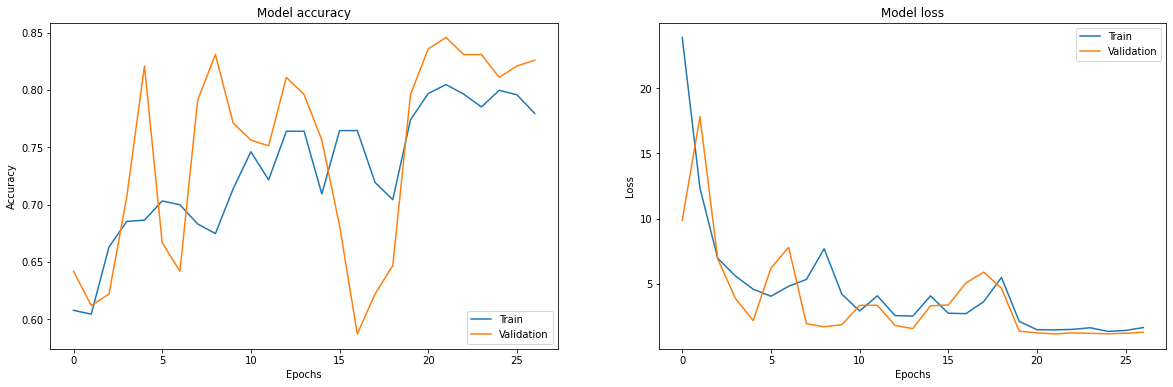

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(20, 6))
    
    # Summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

plot_training_history(model.history)

### Confusion matrix

Loading model ...
ValueError: Custom Keras layers detected.
Loading model with custom objects ...COMPLETE
Processing class prediction ...
159/159 [====================] - 44s 268ms/batch
Generating confusion matrix ... Complete
Generating text based classification report ... Complete
Complete
Classification Report
              precision    recall  f1-score   support

ILLUSTRATION       0.95      0.80      0.87      4368
       MANGA       0.38      0.75      0.50       694

    accuracy                           0.80      5062
   macro avg       0.66      0.77      0.69      5062
weighted avg       0.87      0.80      0.82      5062



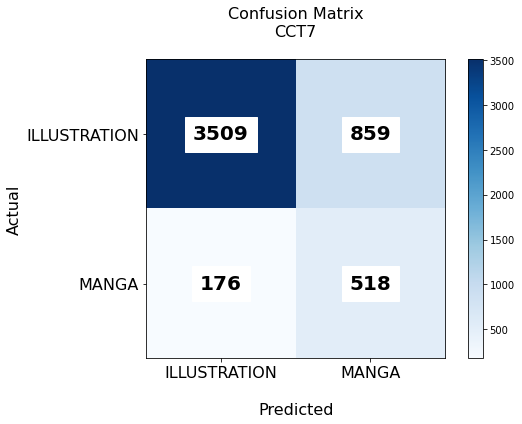

In [11]:
%reset -f

from module.utility.DirectoryProcessor import DirectoryProcessor
from module.evaluate.ConfusionMatrix import ConfusionMatrix
from pathlib import Path

CFG = {
    "dataset_dir": "D:\Github Public\DATASET MANAGER\Blue Archive",
    "extenstions": [".jpg", ".png"],
    "model1": {"h5":".\export model\CCT_I224x224_Conv32_64_128_256_L7_H4_D256_MLP512_2Class.h5",
               "name":"CCT7"},
}

def data_maker():
    # File path processing
    data_list = []
    label_set = set()
    path_list = DirectoryProcessor.get_only_files(CFG["dataset_dir"], CFG["extenstions"], include_sub_dir=True)

    for path in path_list:
        path_obj = Path(path)
        label = path_obj.parts[4]
        data_list.append((path, label))
        label_set.add(label)
    
    label_list = list(sorted(label_set))

    return data_list, label_list

data_list, label_list = data_maker()

report = ConfusionMatrix(
    h5_file=CFG["model1"]["h5"],
    model_name=CFG["model1"]["name"],
    data_list=data_list,
    label_list=label_list,
    force_batch=32,
)
report.print_report()

In terms of performance, `CCT` has significantly fewer parameters than `CNN` based models, yet it performs classification well, even when using a simple CNN structure of `Conv2D -> Maxpooling -> Conv2D -> Maxpooling -> ...`